In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [22]:
# loading CSV files
df_modif_reviews = pd.read_csv('modif_reviews.csv')
df_recipes_filtered = pd.read_csv('recipes_filtered.csv')
fruits_df = pd.read_csv('fruits_data.csv')
vegetables_df = pd.read_csv('vegetables_data.csv')

In [29]:

# merge fruits and vegetables into one dataframe
seasonal_produce_df = pd.concat([fruits_df, vegetables_df])
seasonal_produce_df.columns = ['name', 'month', 'country']

# check for missing values
print("Missing values in df_modif_reviews:", df_modif_reviews.isnull().sum())
print("Missing values in df_recipes_filtered:", df_recipes_filtered.isnull().sum())
print("Missing values in seasonal_produce_df:", seasonal_produce_df.isnull().sum())

# Handle missing values in df_recipes_filtered
# Drop rows where 'name', 'recipecategory', or 'recipeinstructions' is missing
df_recipes_filtered.dropna(subset=['name', 'recipecategory', 'recipeinstructions'], inplace=True)

# Fill missing 'aggregatedrating' and 'reviewcount' with 0
df_recipes_filtered['aggregatedrating'].fillna(0, inplace=True)
df_recipes_filtered['reviewcount'].fillna(0, inplace=True)

# Convert data types if necessary
df_modif_reviews['reviewid'] = df_modif_reviews['reviewid'].astype(int)
df_modif_reviews['recipeid'] = df_modif_reviews['recipeid'].astype(int)
df_modif_reviews['rating'] = df_modif_reviews['rating'].astype(float)

df_recipes_filtered['recipeid'] = df_recipes_filtered['recipeid'].astype(int)
df_recipes_filtered['aggregatedrating'] = df_recipes_filtered['aggregatedrating'].astype(float)
df_recipes_filtered['reviewcount'] = df_recipes_filtered['reviewcount'].astype(float)

# Check the data types and head of the dataframes
print("Data types in df_modif_reviews:\n", df_modif_reviews.dtypes)
print("Data types in df_recipes_filtered:\n", df_recipes_filtered.dtypes)
print("Data types in seasonal_produce_df:\n", seasonal_produce_df.dtypes)

print("Head of df_modif_reviews:\n", df_modif_reviews.head())
print("Head of df_recipes_filtered:\n", df_recipes_filtered.head())
print("Head of seasonal_produce_df:\n", seasonal_produce_df.head())


Missing values in df_modif_reviews: reviewid    0
recipeid    0
rating      0
dtype: int64
Missing values in df_recipes_filtered: Unnamed: 0               0
recipeid                 0
name                     0
cooktime                 0
preptime                 0
totaltime                0
recipecategory           0
recipeingredientparts    0
aggregatedrating         0
reviewcount              0
recipeinstructions       0
dtype: int64
Missing values in seasonal_produce_df: name       0
month      0
country    0
dtype: int64
Data types in df_modif_reviews:
 reviewid      int32
recipeid      int32
rating      float64
dtype: object
Data types in df_recipes_filtered:
 Unnamed: 0                 int64
recipeid                   int32
name                      object
cooktime                   int64
preptime                   int64
totaltime                  int64
recipecategory            object
recipeingredientparts     object
aggregatedrating         float64
reviewcount              floa

In [24]:
import pandas as pd
import numpy as np

# load the datasets
df_modif_reviews = pd.read_csv('modif_reviews.csv')
df_recipes_filtered = pd.read_csv('recipes_filtered.csv')
fruits_df = pd.read_csv('fruits_data.csv')
vegetables_df = pd.read_csv('vegetables_data.csv')

# merge fruits and vegetables into one dataframe
seasonal_produce_df = pd.concat([fruits_df, vegetables_df])
seasonal_produce_df.columns = ['name', 'month', 'country']

# check for missing values
print("Missing values in df_modif_reviews:", df_modif_reviews.isnull().sum())
print("Missing values in df_recipes_filtered:", df_recipes_filtered.isnull().sum())
print("Missing values in seasonal_produce_df:", seasonal_produce_df.isnull().sum())

# handle missing values in df_recipes_filtered
# drop rows where 'name' or 'recipecategory' or 'recipeinstructions' is missing
df_recipes_filtered.dropna(subset=['name', 'recipecategory', 'recipeinstructions'], inplace=True)

# fill missing 'aggregatedrating' and 'reviewcount' with 0
df_recipes_filtered['aggregatedrating'].fillna(0, inplace=True)
df_recipes_filtered['reviewcount'].fillna(0, inplace=True)

# be sure that 'recipeid', 'reviewid', and 'rating' in df_modif_reviews are of correct types
df_modif_reviews['reviewid'] = df_modif_reviews['reviewid'].astype(int)
df_modif_reviews['recipeid'] = df_modif_reviews['recipeid'].astype(int)
df_modif_reviews['rating'] = df_modif_reviews['rating'].astype(float)

# be'recipeid', 'aggregatedrating', and 'reviewcount' in df_recipes_filtered are of correct types
df_recipes_filtered['recipeid'] = df_recipes_filtered['recipeid'].astype(int)
df_recipes_filtered['aggregatedrating'] = df_recipes_filtered['aggregatedrating'].astype(float)
df_recipes_filtered['reviewcount'] = df_recipes_filtered['reviewcount'].astype(float)

# Check the data types and head of the dataframes
print("Data types in df_modif_reviews:\n", df_modif_reviews.dtypes)
print("Data types in df_recipes_filtered:\n", df_recipes_filtered.dtypes)
print("Data types in seasonal_produce_df:\n", seasonal_produce_df.dtypes)

print("Head of df_modif_reviews:\n", df_modif_reviews.head())
print("Head of df_recipes_filtered:\n", df_recipes_filtered.head())
print("Head of seasonal_produce_df:\n", seasonal_produce_df.head())

Missing values in df_modif_reviews: reviewid    0
recipeid    0
rating      0
dtype: int64
Missing values in df_recipes_filtered: recipeid                      0
name                         34
cooktime                      0
preptime                      0
totaltime                     0
recipecategory              751
recipeingredientparts         0
aggregatedrating         253223
reviewcount              247489
recipeinstructions            4
dtype: int64
Missing values in seasonal_produce_df: name       0
month      0
country    0
dtype: int64
Data types in df_modif_reviews:
 reviewid      int32
recipeid      int32
rating      float64
dtype: object
Data types in df_recipes_filtered:
 recipeid                   int32
name                      object
cooktime                   int64
preptime                   int64
totaltime                  int64
recipecategory            object
recipeingredientparts     object
aggregatedrating         float64
reviewcount              float64
recipe

c:\Users\benoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\benoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\benoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\benoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

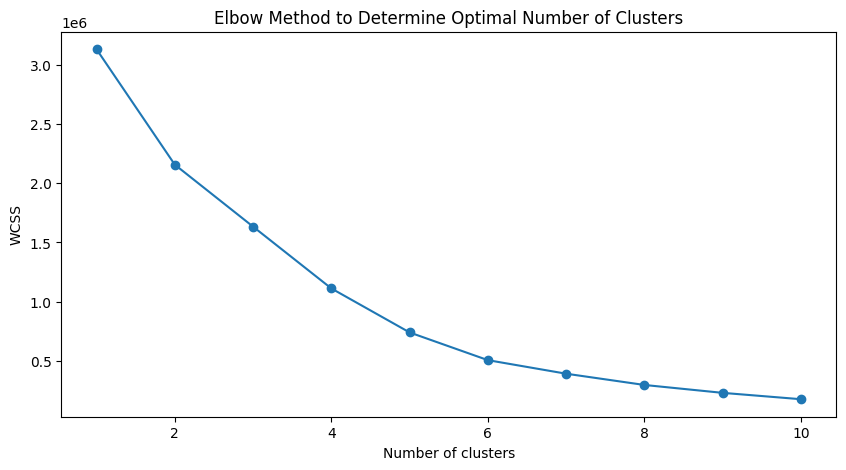

c:\Users\benoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


        recipeid                                              name  \
1             39                                           biryani   
3             41                      carinas tofuvegetable kebabs   
4             42                                      cabbage soup   
6             44                            warm chicken a la king   
11            49                          chicken breasts lombardi   
...          ...                                               ...   
521711    541367                             thick peanut pancakes   
521718    541374                                  mamas bean salad   
521719    541375                    amazing ground beef stroganoff   
521722    541378                          megs pumpkin spice bread   
521724    541380  roast prime rib au poivre with mixed peppercorns   

        aggregatedrating  reviewcount  cluster  
1                    3.0          1.0        0  
3                    4.5          2.0        0  
4           

In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the datasets
df_modif_reviews = pd.read_csv('modif_reviews.csv')
df_recipes_filtered = pd.read_csv('recipes_filtered_cleaned.csv')
fruits_df = pd.read_csv('fruits_data.csv')
vegetables_df = pd.read_csv('vegetables_data.csv')

# Merge fruits and vegetables into one dataframe
seasonal_produce_df = pd.concat([fruits_df, vegetables_df])
seasonal_produce_df.columns = ['product_name', 'month', 'country']

# Convert month names to numeric values
month_mapping = {
    'january': 1, 'february': 2, 'march': 3, 'april': 4,
    'may': 5, 'june': 6, 'july': 7, 'august': 8,
    'september': 9, 'october': 10, 'november': 11, 'december': 12
}
seasonal_produce_df['month'] = seasonal_produce_df['month'].str.lower().map(month_mapping)

# Handle missing values in df_recipes_filtered
df_recipes_filtered.dropna(subset=['name', 'recipecategory', 'recipeinstructions'], inplace=True)
df_recipes_filtered['aggregatedrating'].fillna(0, inplace=True)
df_recipes_filtered['reviewcount'].fillna(0, inplace=True)
df_recipes_filtered['recipeingredientparts'].fillna('', inplace=True)
df_recipes_filtered['recipeingredientparts'] = df_recipes_filtered['recipeingredientparts'].str.lower()
df_recipes_filtered['name'] = df_recipes_filtered['name'].str.lower()
df_recipes_filtered['recipecategory'] = df_recipes_filtered['recipecategory'].str.lower()

df_modif_reviews['reviewid'] = df_modif_reviews['reviewid'].astype(int)
df_modif_reviews['recipeid'] = df_modif_reviews['recipeid'].astype(int)
df_modif_reviews['rating'] = df_modif_reviews['rating'].astype(float)
df_recipes_filtered['recipeid'] = df_recipes_filtered['recipeid'].astype(int)
df_recipes_filtered['aggregatedrating'] = df_recipes_filtered['aggregatedrating'].astype(float)
df_recipes_filtered['reviewcount'] = df_recipes_filtered['reviewcount'].astype(float)

# Define a function to create features for clustering
def create_features(row, seasonal_product_names):
    ingredients = row['recipeingredientparts'].split(', ')
    seasonal_ingredients = [ingredient for ingredient in ingredients if ingredient in seasonal_product_names]
    return len(seasonal_ingredients)

# Example usage to define seasonal_product_names
selected_country = 'denmark'
selected_month = 'august'
available_product = ['apple']

selected_month_numeric = month_mapping[selected_month.lower()]
seasonal_products = seasonal_produce_df[
    (seasonal_produce_df['country'] == selected_country) &
    (seasonal_produce_df['month'] == selected_month_numeric)
]
seasonal_product_names = seasonal_products['product_name'].str.lower().values

# Apply the create_features function to add a new column
df_recipes_filtered['num_seasonal_ingredients'] = df_recipes_filtered.apply(create_features, axis=1, args=(seasonal_product_names,))

# Select features for clustering
features = ['aggregatedrating', 'reviewcount', 'cooktime', 'preptime', 'totaltime', 'num_seasonal_ingredients']
X = df_recipes_filtered[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the elbow method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow method result
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Fit the K-means model with the optimal number of clusters (e.g., 4)
optimal_clusters = 4  # Replace this with the actual optimal number of clusters determined from the plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_recipes_filtered['cluster'] = kmeans.fit_predict(X_scaled)

# Recommendation function
def recommend_recipes(selected_country, selected_month, available_product):
    # Convert month name to numeric value
    selected_month_numeric = month_mapping[selected_month.lower()]
    
    # Filter seasonal produce based on user selection
    seasonal_products = seasonal_produce_df[
        (seasonal_produce_df['country'] == selected_country) &
        (seasonal_produce_df['month'] == selected_month_numeric)
    ]
    
    # Get the list of seasonal products
    seasonal_product_names = seasonal_products['product_name'].str.lower().values
    
    # Find recipes with seasonal products and cluster info
    def ingredient_match(ingredients, products):
        return any(product in ingredients for product in products)
    
    matching_recipes = df_recipes_filtered[
        df_recipes_filtered['recipeingredientparts'].apply(ingredient_match, args=(seasonal_product_names,))
    ]
    
    if matching_recipes.empty:
        return "No matching recipes found."
    else:
        # Return the recipes along with their cluster information
        return matching_recipes[['recipeid', 'name', 'aggregatedrating', 'reviewcount', 'cluster']]

# Example usage
recommended_recipes = recommend_recipes(selected_country, selected_month, available_product)
print(recommended_recipes)


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# load the datasets
df_modif_reviews = pd.read_csv('modif_reviews.csv')
df_recipes_filtered = pd.read_csv('recipes_filtered_cleaned.csv')
fruits_df = pd.read_csv('fruits_data.csv')
vegetables_df = pd.read_csv('vegetables_data.csv')

# merge fruits and vegetables into one dataframe
seasonal_produce_df = pd.concat([fruits_df, vegetables_df])
seasonal_produce_df.columns = ['product_name', 'month', 'country']

# convert month names to numeric values
month_mapping = {
    'january': 1, 'february': 2, 'march': 3, 'april': 4,
    'may': 5, 'june': 6, 'july': 7, 'august': 8,
    'september': 9, 'october': 10, 'november': 11, 'december': 12
}
seasonal_produce_df['month'] = seasonal_produce_df['month'].str.lower().map(month_mapping)

# function to display seasonal produce and get user selection
def display_seasonal_produce(country, month):
    month_numeric = month_mapping[month.lower()]
    seasonal_products = seasonal_produce_df[
        (seasonal_produce_df['country'].str.lower() == country.lower()) &
        (seasonal_produce_df['month'] == month_numeric)
    ]
    print(f"Seasonal Fruits and Vegetables for {country.capitalize()} in {month.capitalize()}:")
    print(seasonal_products[['product_name']].to_string(index=False))
    return seasonal_products['product_name'].str.lower().values

# define a function to create features for clustering
def create_features(row, seasonal_product_names):
    ingredients = row['recipeingredientparts'].split(', ')
    seasonal_ingredients = [ingredient for ingredient in ingredients if ingredient in seasonal_product_names]
    return len(seasonal_ingredients)

# example usage to define seasonal_product_names
selected_country = 'denmark'
selected_month = 'august'

seasonal_product_names = display_seasonal_produce(selected_country, selected_month)

# aassuming the user selects available products
# for example, user selects 'cauliflower' and 'pear' from the list
user_selected_produce = ['cauliflower', 'pear']

# apply the create_features function to add a new column
df_recipes_filtered['num_seasonal_ingredients'] = df_recipes_filtered.apply(create_features, axis=1, args=(user_selected_produce,))

# select features for clustering
features = ['aggregatedrating', 'reviewcount', 'cooktime', 'preptime', 'totaltime', 'num_seasonal_ingredients']
X = df_recipes_filtered[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the K-means model with the optimal number of clusters (4 clusters) and set n_init explicitly
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
df_recipes_filtered['cluster'] = kmeans.fit_predict(X_scaled)

# Recommendation function
def recommend_recipes(selected_country, selected_month, selected_produce):
    # Convert month name to numeric value
    selected_month_numeric = month_mapping[selected_month.lower()]
    
    # Filter seasonal produce based on user selection
    seasonal_products = seasonal_produce_df[
        (seasonal_produce_df['country'] == selected_country) &
        (seasonal_produce_df['month'] == selected_month_numeric)
    ]
    
    # Get the list of seasonal products
    seasonal_product_names = seasonal_products['product_name'].str.lower().values
    
    # Find recipes with seasonal products and cluster info
    def ingredient_match(ingredients, products):
        return any(product in ingredients for product in products)
    
    matching_recipes = df_recipes_filtered[
        df_recipes_filtered['recipeingredientparts'].apply(ingredient_match, args=(selected_produce,))
    ]
    
    if matching_recipes.empty:
        return "No matching recipes found."
    else:
        # Return the recipes along with their details and cluster information
        return matching_recipes[['recipeid', 'name', 'aggregatedrating', 'reviewcount', 'cluster', 'recipeingredientparts', 'recipeinstructions']]

# Example usage
recommended_recipes = recommend_recipes(selected_country, selected_month, user_selected_produce)
display(recommended_recipes)


Seasonal Fruits and Vegetables for Denmark in August:
        product_name
               apple
          blackberry
        blackcurrant
           blueberry
           muskmelon
                pear
                plum
  beech hat mushroom
            beetroot
         bell pepper
            broccoli
             cabbage
              carrot
         cauliflower
            celeriac
              celery
               chili
            cucumber
    emperor mushroom
      enoki mushroom
              fennel
    frillice lettuce
          green bean
    heart of lettuce
     iceberg lettuce
                leek
lollo bionda lettuce
 lollo rosso lettuce
            mushroom
    oak leaf lettuce
               onion
     oyster mushroom
            pak choi
             parsnip
                 pea
 portobello mushroom
             pumpkin
         red cabbage
             rhubarb
     romaine lettuce
             salsify
             shallot
             spinach
              squash
 

,recipeid,name,aggregatedrating,reviewcount,cluster,recipeingredientparts,recipeinstructions
209,264,trifle,4.0,3.0,0,egg white substitute granulated sugar soymilk ...,preheat the oven to 350 degrees beat the egg w...
213,270,spiced pear butter,5.0,9.0,0,pears innamon sticks allspice loves sugar,combine pears and apple juice in a large dutch...
216,273,winter pear butter,5.0,3.0,0,pears sugar brandy water,peel quarter and ore the pears hop in 12inch p...
234,292,curried vegetables,0.0,0.0,1,cauliflower arrots elery onion mayonnaise salt...,cook the auliflower arrots elery and onion in ...
285,347,roasted tomato and mint salsa,0.0,0.0,1,roma tomatoes garlic love lime juice extra vir...,with a omal or black iron skillet over mediumh...
...,...,...,...,...,...,...,...
521152,540793,vegetable masala,0.0,0.0,1,cauliflower potatoes whole umin seed onion gro...,cut the auliflower into florets about 25 mm ac...
521201,540844,grilled brie ham amp pear sandwich,0.0,0.0,1,bosc pear pomegranate molasses black pepper bu...,assemble sandwich by placing slices of brie fo...
521246,540892,vegetarian cauliflower cake,0.0,0.0,1,cauliflower kosher salt red onion olive oil fr...,preheat the oven to 400ºf200ºc place the aulif...
521463,541115,spicy roasted vegetable soup with leftover gri...,0.0,0.0,1,sweet potato baby potatoes turnip parsnip arro...,1 preheat oven to 425 degrees f line 2 large s...
